# Imports and Session Creation

In [1]:
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql import SparkSession

import pandas as pd

Create Spark Session

In [2]:
spark = SparkSession.builder.appName("OSA").getOrCreate()

# Schema Definitions

Inventory Schema

In [3]:
inventory_schema = StructType([
  StructField('date',DateType()),
  StructField('store_id',IntegerType()),
  StructField('sku',IntegerType()),
  StructField('product_category',StringType()),
  StructField('total_sales_units',IntegerType()),
  StructField('on_hand_inventory_units',IntegerType()),
  StructField('replenishment_units',IntegerType()),
  StructField('inventory_pipeline',IntegerType()),
  StructField('units_in_transit',IntegerType()),
  StructField('units_in_dc',IntegerType()),
  StructField('units_on_order',IntegerType()),
  StructField('units_under_promotion',IntegerType()),
  StructField('shelf_capacity',IntegerType())
  ])

Vendor Schema

In [7]:
vendor_schema = StructType([
  StructField('key',IntegerType()),
  StructField('vendor_id',IntegerType()),
  StructField('sub_vendor_id',IntegerType()),
  StructField('store_id',IntegerType()),
  StructField('sku',IntegerType()),
  StructField('lead_time_in_dc',IntegerType()),
  StructField('lead_time_in_transit',IntegerType()),
  StructField('lead_time_on_order',IntegerType()),
])

Data from:
https://raw.githubusercontent.com/tredenceofficial/OSA-Data/main/osa_raw_data.csv
and
https://raw.githubusercontent.com/tredenceofficial/OSA-Data/main/vendor_leadtime_info.csv

In [8]:
inventory_data = spark.read.csv('/content/osa_raw_data.csv', header=True, schema=inventory_schema, dateFormat="yyyyMMdd")
vendor_data = spark.read.csv('/content/vendor_lead_time.csv', header=True, schema=vendor_schema)

inventory_data.show()
vendor_data.show()

+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+----------------+-----------+--------------+---------------------+--------------+
|      date|store_id|sku|product_category|total_sales_units|on_hand_inventory_units|replenishment_units|inventory_pipeline|units_in_transit|units_in_dc|units_on_order|units_under_promotion|shelf_capacity|
+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+----------------+-----------+--------------+---------------------+--------------+
|2019-01-02|      63| 57|     Category 04|                0|                      8|                  0|                16|               0|          0|             8|                    0|            32|
|2019-01-04|      63| 57|     Category 04|                0|                      7|                  0|                14|               0|          8|             0|             

# Handle Missing Records
Since not all products have a sale every day, we have to fill in the missing records with a 0 sale say

In [16]:
from datetime import date
end_date = inventory_data.agg(f.max('date')).collect()[0][0]
start_date = inventory_data.agg(f.min('date')).collect()[0][0]
date_range_df = spark.createDataFrame([(start_date, end_date)], ['start_date', 'end_date'])

date_range_df = date_range_df.withColumn(
    "date_seq",
    f.explode(f.sequence(f.to_date(date_range_df.start_date), f.to_date(date_range_df.end_date)))
)

date_list = [row.date_seq for row in date_range_df.select("date_seq").collect()]

print(f"The list of dates is: {date_list}")


The list of dates is: [datetime.date(2019, 1, 1), datetime.date(2019, 1, 2), datetime.date(2019, 1, 3), datetime.date(2019, 1, 4), datetime.date(2019, 1, 5), datetime.date(2019, 1, 6), datetime.date(2019, 1, 7), datetime.date(2019, 1, 8), datetime.date(2019, 1, 9), datetime.date(2019, 1, 10), datetime.date(2019, 1, 11), datetime.date(2019, 1, 12), datetime.date(2019, 1, 13), datetime.date(2019, 1, 14), datetime.date(2019, 1, 15), datetime.date(2019, 1, 16), datetime.date(2019, 1, 17), datetime.date(2019, 1, 18), datetime.date(2019, 1, 19), datetime.date(2019, 1, 20), datetime.date(2019, 1, 21), datetime.date(2019, 1, 22), datetime.date(2019, 1, 23), datetime.date(2019, 1, 24), datetime.date(2019, 1, 25), datetime.date(2019, 1, 26), datetime.date(2019, 1, 27), datetime.date(2019, 1, 28), datetime.date(2019, 1, 29), datetime.date(2019, 1, 30), datetime.date(2019, 1, 31), datetime.date(2019, 2, 1), datetime.date(2019, 2, 2), datetime.date(2019, 2, 3), datetime.date(2019, 2, 4), datetime.d

Convert the date list to an RDD then to a dataframe

In [17]:
date_rdd = spark.sparkContext.parallelize(date_list)
date_df = spark.createDataFrame(date_rdd, DateType()).toDF("date")
date_df.show()

+----------+
|      date|
+----------+
|2019-01-01|
|2019-01-02|
|2019-01-03|
|2019-01-04|
|2019-01-05|
|2019-01-06|
|2019-01-07|
|2019-01-08|
|2019-01-09|
|2019-01-10|
|2019-01-11|
|2019-01-12|
|2019-01-13|
|2019-01-14|
|2019-01-15|
|2019-01-16|
|2019-01-17|
|2019-01-18|
|2019-01-19|
|2019-01-20|
+----------+
only showing top 20 rows



Create a list of all the sku's at each store

In [18]:

store_skus = (
    inventory_data
    .select('store_id', 'sku', 'product_category')
    .groupBy('store_id', 'sku')
    .agg(f.last('product_category').alias('product_category'))
)
store_skus.show()

+--------+---+----------------+
|store_id|sku|product_category|
+--------+---+----------------+
|      63| 57|     Category 04|
|      98| 64|     Category 01|
|     164| 76|     Category 05|
|     171| 64|     Category 01|
|     178| 64|     Category 01|
|     206| 64|     Category 01|
|     209| 64|     Category 01|
|     210|148|     Category 03|
|     232| 64|     Category 01|
|     249| 64|     Category 01|
|     273|110|     Category 02|
|     274| 64|     Category 01|
|     303| 83|     Category 05|
|     334| 52|     Category 06|
|     337| 64|     Category 01|
|     338| 64|     Category 01|
|     339| 64|     Category 01|
|     371| 64|     Category 01|
|     373| 64|     Category 01|
|     377| 64|     Category 01|
+--------+---+----------------+
only showing top 20 rows



Create the complete set of inventory records using the rest of the data

In [39]:
inventory_with_gaps = (
  date_df
    .crossJoin(store_skus)
    .join(
      inventory_data.drop('product_category'),
      on=['date','store_id','sku'],
      how='leftouter'
      )
  )
print(inventory_with_gaps.count())

85400


Fill in the missing values using the previous/next days inventory

In [20]:
# copy dataframe to enable manipulations in loop
inventory_cleansed = inventory_with_gaps

# apply forward fill to appropriate columns
for c in ['shelf_capacity', 'on_hand_inventory_units']:
  inventory_cleansed = (
    inventory_cleansed
      .withColumn(
          c,
          f.expr('LAST({0}, True) OVER(PARTITION BY store_id, sku ORDER BY date)'.format(c)) # get last non-null prior value (aka forward-fill)
           )
        )

# apply default value of 0 to appropriate columns
inventory_cleansed = (
  inventory_cleansed
    .fillna(
      0,
      [ 'total_sales_units',
        'units_under_promotion',
        'units_in_transit',
        'units_in_dc',
        'units_on_order',
        'replenishment_units',
        'inventory_pipeline'
        ]
      )
  )

# display data with imputed values
inventory_cleansed.show()

+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+----------------+-----------+--------------+---------------------+--------------+
|      date|store_id|sku|product_category|total_sales_units|on_hand_inventory_units|replenishment_units|inventory_pipeline|units_in_transit|units_in_dc|units_on_order|units_under_promotion|shelf_capacity|
+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+----------------+-----------+--------------+---------------------+--------------+
|2019-01-01|      63| 57|     Category 04|                0|                   NULL|                  0|                 0|               0|          0|             0|                    0|          NULL|
|2019-01-02|      63| 57|     Category 04|                0|                      8|                  0|                16|               0|          0|             8|             

# Create Flags
Create flags based on inventory events such as promotions used to drive sales and events when new units are added to the inventory

In [21]:
# derive inventory flags
inventory_final = (
  inventory_cleansed
    .withColumn('promotion_flag', f.expr('CASE WHEN units_under_promotion > 0 THEN 1 ELSE 0 END'))
    .withColumn('replenishment_flag', f.expr('CASE WHEN replenishment_units > 0 THEN 1 ELSE 0 END'))
    )

inventory_final.show()

+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+----------------+-----------+--------------+---------------------+--------------+--------------+------------------+
|      date|store_id|sku|product_category|total_sales_units|on_hand_inventory_units|replenishment_units|inventory_pipeline|units_in_transit|units_in_dc|units_on_order|units_under_promotion|shelf_capacity|promotion_flag|replenishment_flag|
+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+----------------+-----------+--------------+---------------------+--------------+--------------+------------------+
|2019-01-01|      63| 57|     Category 04|                0|                   NULL|                  0|                 0|               0|          0|             0|                    0|          NULL|             0|                 0|
|2019-01-02|      63| 57|     Category 04|  

# Phantom Inventory
Identify inventory decreases that are untracked (items that are lost, stolen, damaged, etc)

In [23]:
# phantom inventory calculations
phantom_inventory = (
  inventory_final

    # average daily sales
    .withColumn('daily_sales_units', f.expr('AVG(total_sales_units) OVER(PARTITION BY store_id, sku ORDER BY date)'))

    # on-hand inventory units at the end of previous day
    # for dates with no prior day inventory units, provide alt calculation
    .withColumn('start_on_hand_units', f.expr('''
      COALESCE(
        LAG(on_hand_inventory_units, 1) OVER(PARTITION BY store_id, sku ORDER BY date),
        on_hand_inventory_units + total_sales_units - replenishment_units
        )
        '''))

    # on-hand inventory units at end of day
    .withColumn('end_on_hand_units', f.expr('COALESCE(on_hand_inventory_units, 0)'))

    # calculate phantom inventory as difference in:
    # (previous day's on-hand inventory + current day's replenished units - current day's sales units) and current day's end-of-day inventory
    .withColumn('phantom_inventory', f.expr('start_on_hand_units + replenishment_units - total_sales_units - end_on_hand_units'))

    # flag only when phantom inventory is at least 5 times average daily sales
    .withColumn('phantom_inventory_ind', f.expr('''
      CASE
        WHEN phantom_inventory <> 0 AND ABS(phantom_inventory) > 5 * daily_sales_units THEN 1
        ELSE 0
        END'''))

    .select(
      'date',
      'store_id',
      'sku',
      'daily_sales_units',
      'start_on_hand_units',
      'replenishment_units',
      'total_sales_units',
      'end_on_hand_units',
      'phantom_inventory',
      'phantom_inventory_ind'
      )
    )

# display results
phantom_inventory.show()

+----------+--------+---+------------------+-------------------+-------------------+-----------------+-----------------+-----------------+---------------------+
|      date|store_id|sku| daily_sales_units|start_on_hand_units|replenishment_units|total_sales_units|end_on_hand_units|phantom_inventory|phantom_inventory_ind|
+----------+--------+---+------------------+-------------------+-------------------+-----------------+-----------------+-----------------+---------------------+
|2019-01-01|      63| 57|               0.0|               NULL|                  0|                0|                0|             NULL|                    0|
|2019-01-02|      63| 57|               0.0|                  8|                  0|                0|                8|                0|                    0|
|2019-01-03|      63| 57|               0.0|                  8|                  0|                0|                8|                0|                    0|
|2019-01-04|      63| 57|         

In [48]:
count = phantom_inventory.filter(phantom_inventory.end_on_hand_units == 0).count()
print(f"The number of instances where end_on_hand_units = 0 is: {count}")

The number of instances where end_on_hand_units = 0 is: 16912


## Graphing Phantom Inventory

In [40]:
phantom_inventory_graph = (
                           phantom_inventory
                           .withColumn('expected_inventory', f.expr('start_on_hand_units + replenishment_units - total_sales_units'))
                           .withColumn('actual_inventory', f.expr('end_on_hand_units'))
                           .select(
                               'date',
                               'expected_inventory',
                               'actual_inventory',
                           )
                           )


daily_expected_inventory = phantom_inventory_graph.groupBy('date').agg(f.sum('expected_inventory').alias('expected_inventory'))
daily_actual_inventory = phantom_inventory_graph.groupBy('date').agg(f.sum('actual_inventory').alias('actual_inventory'))
phantom_inventory_graph.show()
print(daily_expected_inventory.show())

+----------+------------------+----------------+
|      date|expected_inventory|actual_inventory|
+----------+------------------+----------------+
|2019-01-01|              NULL|               0|
|2019-01-02|                 8|               8|
|2019-01-03|                 8|               8|
|2019-01-04|                 8|               7|
|2019-01-05|                12|               5|
|2019-01-06|                 3|              11|
|2019-01-07|                11|              11|
|2019-01-08|                11|              11|
|2019-01-09|                 8|               7|
|2019-01-10|                 5|               5|
|2019-01-11|                 5|               5|
|2019-01-12|                 5|               5|
|2019-01-13|                 5|              13|
|2019-01-14|                13|              13|
|2019-01-15|                13|              13|
|2019-01-16|                13|              14|
|2019-01-17|                14|              14|
|2019-01-18|        

In [41]:
import matplotlib.pyplot as plt


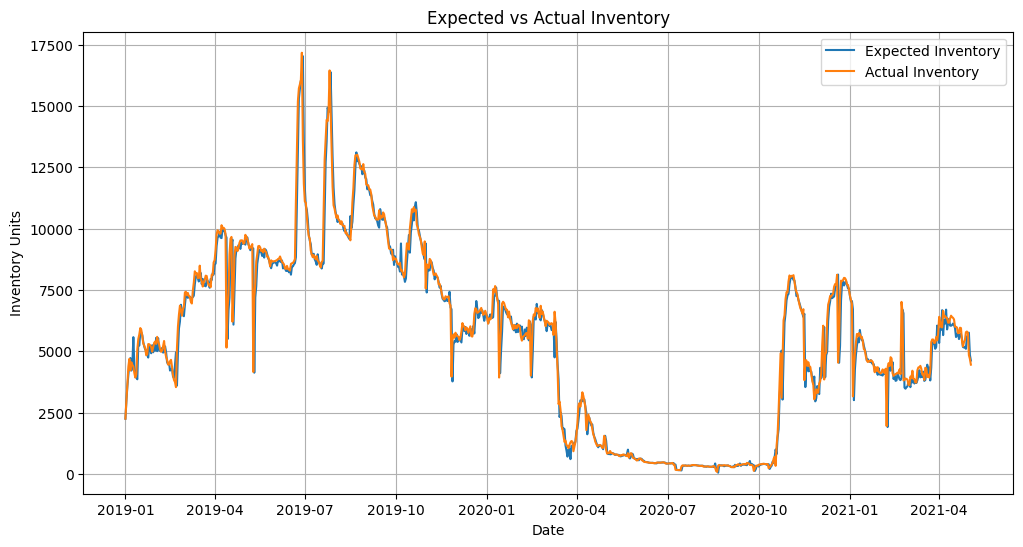

In [42]:
daily_inventory = daily_expected_inventory.join(daily_actual_inventory, on='date', how='inner')
daily_inventory = daily_inventory.orderBy('date')

# Convert the joined DataFrame to Pandas
daily_inventory_pd = daily_inventory.toPandas()


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_inventory_pd['date'], daily_inventory_pd['expected_inventory'], label='Expected Inventory')
plt.plot(daily_inventory_pd['date'], daily_inventory_pd['actual_inventory'], label='Actual Inventory')
plt.xlabel('Date')
plt.ylabel('Inventory Units')
plt.title('Expected vs Actual Inventory')
plt.legend()
plt.grid(True)
plt.show()

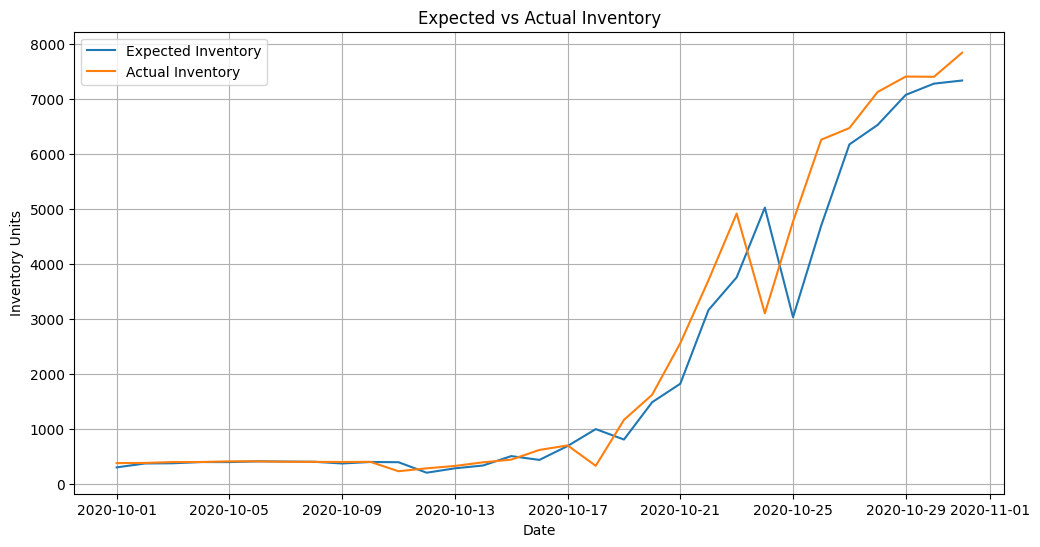

In [43]:
daily_inventory = daily_inventory.filter(
    (f.col("date") >= f.lit("2020-10-01")) & (f.col("date") <= f.lit("2020-10-31"))
)

# Convert the joined DataFrame to Pandas
daily_inventory_pd = daily_inventory.toPandas()


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_inventory_pd['date'], daily_inventory_pd['expected_inventory'], label='Expected Inventory')
plt.plot(daily_inventory_pd['date'], daily_inventory_pd['actual_inventory'], label='Actual Inventory')
plt.xlabel('Date')
plt.ylabel('Inventory Units')
plt.title('Expected vs Actual Inventory')
plt.legend()
plt.grid(True)
plt.show()

# Identify Out of Stocks

## Join with Phantom Inventory

In [24]:
# combine inventory with phantom inventory and min lead times
inventory_with_pi = (
  inventory_final.alias('inv')
    .join(phantom_inventory.alias('pi'), on=['store_id','sku','date'])

    # limit fields to use moving forward
    .selectExpr(
      'inv.store_id',
      'inv.sku',
      'inv.date',
      'inv.product_category',
      'inv.on_hand_inventory_units',
      'inv.total_sales_units',
      'inv.replenishment_units',
      'inv.replenishment_flag',
      'inv.units_on_order',
      'inv.units_in_transit',
      'inv.units_in_dc',
      'pi.phantom_inventory'
      )

  # correct inventory values to enable calculations
  .withColumn('phantom_inventory', f.expr('COALESCE(phantom_inventory, 0)'))
  .withColumn('on_hand_inventory_units', f.expr('''
              CASE
                WHEN on_hand_inventory_units < 0 THEN 0
                ELSE on_hand_inventory_units
                END''')
             )
   .withColumn('replenishment_units', f.expr('''
              CASE
                WHEN replenishment_flag = 1 THEN replenishment_units
                ELSE 0
                END''')
             )

  # initialize estimated on-hand inventory field
   .withColumn('estimated_on_hand_inventory', f.lit(0))
  )

inventory_with_pi.show()

+--------+---+----------+----------------+-----------------------+-----------------+-------------------+------------------+--------------+----------------+-----------+-----------------+---------------------------+
|store_id|sku|      date|product_category|on_hand_inventory_units|total_sales_units|replenishment_units|replenishment_flag|units_on_order|units_in_transit|units_in_dc|phantom_inventory|estimated_on_hand_inventory|
+--------+---+----------+----------------+-----------------------+-----------------+-------------------+------------------+--------------+----------------+-----------+-----------------+---------------------------+
|      63| 57|2019-01-01|     Category 04|                   NULL|                0|                  0|                 0|             0|               0|          0|                0|                          0|
|      63| 57|2019-01-02|     Category 04|                      8|                0|                  0|                 0|             8|      

## Estimate Inventory On-Hand

In [25]:
# iterate over inventory to calculate current inventory levels
def get_estimated_inventory(inventory_pd: pd.DataFrame) -> pd.DataFrame:

  inventory_pd.sort_values('date', inplace=True)

  # iterate over records in inventory data
  for i in range(1,len(inventory_pd)):

    # get component values
    previous_inv = inventory_pd.estimated_on_hand_inventory.iloc[i-1]
    if previous_inv < 0: previous_inv = 0

    replenishment_units = inventory_pd.replenishment_units.iloc[i]
    total_sales_units = inventory_pd.total_sales_units.iloc[i]
    phantom_inventory_units = inventory_pd.phantom_inventory.iloc[i]
    on_hand_inventory_units = inventory_pd.on_hand_inventory_units.iloc[i]

    # calculate estimated on-hand inventory
    estimated_on_hand_inventory = previous_inv + replenishment_units - total_sales_units - phantom_inventory_units
    if estimated_on_hand_inventory < 0: estimated_on_hand_inventory = 0
    if estimated_on_hand_inventory > on_hand_inventory_units: estimated_on_hand_inventory = on_hand_inventory_units

    inventory_pd.estimated_on_hand_inventory.iloc[i] = estimated_on_hand_inventory

  return inventory_pd


# calculate estimated on-hand inventory
inventory_on_hand = (
  inventory_with_pi
  .groupby('store_id', 'sku')
    .applyInPandas( get_estimated_inventory, schema=inventory_with_pi.schema )
  )

inventory_on_hand.show(20)

+--------+---+----------+----------------+-----------------------+-----------------+-------------------+------------------+--------------+----------------+-----------+-----------------+---------------------------+
|store_id|sku|      date|product_category|on_hand_inventory_units|total_sales_units|replenishment_units|replenishment_flag|units_on_order|units_in_transit|units_in_dc|phantom_inventory|estimated_on_hand_inventory|
+--------+---+----------+----------------+-----------------------+-----------------+-------------------+------------------+--------------+----------------+-----------+-----------------+---------------------------+
|      63| 57|2019-01-01|     Category 04|                   NULL|                0|                  0|                 0|             0|               0|          0|                0|                          0|
|      63| 57|2019-01-02|     Category 04|                      8|                0|                  0|                 0|             8|      

## Calculate Average On-Hand and Average Daily Sales Metrics

In [26]:
inventory_with_metrics = (
  inventory_on_hand

    # AVERAGE ON-HAND UNITS PRIOR TO REPLENISHMENT
    # ------------------------------------------------------------------------------------
    # getting prior day's on-hand inventory only for the days with replenishment
    .withColumn('prior_inventory', f.expr('LAG(estimated_on_hand_inventory, 1) OVER(PARTITION BY store_id, sku ORDER BY date)'))
    .withColumn('prior_inventory', f.expr('COALESCE(prior_inventory,0)'))
    .withColumn('prior_inventory', f.expr('CASE WHEN replenishment_flag=1 THEN prior_inventory ELSE 0 END'))

    # calculating rolling average of prior day's on-hand inventory for days with replenishment (over last 90 days)
    .withColumn('rolling_stock_onhand', f.expr('''
      SUM(prior_inventory) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 90 PRECEDING AND CURRENT ROW) /
      (SUM(replenishment_flag) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 90 PRECEDING AND CURRENT ROW) + 1)
      '''
      ))
    .withColumn('rolling_min_expected_stock', f.expr('CASE WHEN replenishment_flag != 1 THEN 0 ELSE rolling_stock_onhand END'))
    .withColumn('rolling_min_expected_stock', f.expr('COALESCE(rolling_min_expected_stock,0)'))

    # fixing the inventory values for all dates through forward fill
    .withColumn('min_expected_stock', f.expr('NULLIF(rolling_min_expected_stock,0)'))
    .withColumn('min_expected_stock', f.expr('LAST(min_expected_stock, True) OVER(PARTITION BY store_id, sku ORDER BY date)'))
    .withColumn('min_expected_stock', f.expr('COALESCE(min_expected_stock, 0)'))
    # ------------------------------------------------------------------------------------

    # AVERAGE DAILY SALES
    # ------------------------------------------------------------------------------------
    # getting daily sales velocity
    .withColumn('daily_sales_units', f.expr('AVG(total_sales_units) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 90 PRECEDING AND CURRENT ROW)'))
    .withColumn('daily_sales_units', f.expr('LAST(daily_sales_units, True) OVER(PARTITION BY store_id, sku ORDER BY date)'))
    .withColumn('daily_sales_units', f.expr('COALESCE(daily_sales_units, 0)'))
    # ------------------------------------------------------------------------------------
  )

inventory_with_metrics.show(20)

+--------+---+----------+----------------+-----------------------+-----------------+-------------------+------------------+--------------+----------------+-----------+-----------------+---------------------------+---------------+--------------------+--------------------------+------------------+------------------+
|store_id|sku|      date|product_category|on_hand_inventory_units|total_sales_units|replenishment_units|replenishment_flag|units_on_order|units_in_transit|units_in_dc|phantom_inventory|estimated_on_hand_inventory|prior_inventory|rolling_stock_onhand|rolling_min_expected_stock|min_expected_stock| daily_sales_units|
+--------+---+----------+----------------+-----------------------+-----------------+-------------------+------------------+--------------+----------------+-----------+-----------------+---------------------------+---------------+--------------------+--------------------------+------------------+------------------+
|      63| 57|2019-01-01|     Category 04|          

## Calculate Shortest Lead Time for Each Store-SKU

In [27]:
# calculate shortest lead time for each store-sku combination
lead_time = (
  vendor_data
    .withColumn('min_lead_time', f.expr('LEAST(lead_time_in_dc, lead_time_in_transit, lead_time_on_order)'))
    .select('store_id', 'sku', 'min_lead_time', 'lead_time_in_dc', 'lead_time_in_transit', 'lead_time_on_order')
    )

lead_time.show()

+--------+---+-------------+---------------+--------------------+------------------+
|store_id|sku|min_lead_time|lead_time_in_dc|lead_time_in_transit|lead_time_on_order|
+--------+---+-------------+---------------+--------------------+------------------+
|    1763|  1|            3|              4|                   3|                 7|
|    1763|  2|            1|              2|                   1|                 7|
|    1843|  2|            1|              2|                   1|                 7|
|    1763|  3|            3|              4|                   3|                 7|
|     486|  6|            1|              2|                   1|                 8|
|    1587|  7|            2|              3|                   2|                 9|
|    1556|  8|            3|              4|                   3|                 7|
|    1283| 39|            2|              3|                   2|                 6|
|    1763| 46|            1|              2|                   1|

## Determine Safety Stock

In [28]:
inventory_safety_stock = (
  inventory_with_metrics
    .join(lead_time, on=['store_id','sku'], how='leftouter')

    # safety stock for sales velocity is avg daily sales units * min_lead_time
    .withColumn('ss_sales_velocity', f.expr('daily_sales_units * min_lead_time'))

    # use the lower of the min_expected_stock at replenishment or sales_velocity-derived stock requirement as safety stock
    .withColumn('safety_stock', f.expr('CASE WHEN min_expected_stock < ss_sales_velocity THEN min_expected_stock ELSE ss_sales_velocity END'))
    .withColumn('safety_stock', f.expr('CASE WHEN replenishment_flag != 1 THEN 0 ELSE safety_stock END'))
    .withColumn('safety_stock', f.expr('COALESCE(safety_stock,0)'))
    .withColumn('safety_stock', f.expr('CASE WHEN safety_stock=0 THEN min_expected_stock ELSE safety_stock END'))

    .select(
      'date',
      'store_id',
      'sku',
      'product_category',
      'total_sales_units',
      'on_hand_inventory_units',
      'replenishment_units',
      'replenishment_flag',
      'phantom_inventory',
      'estimated_on_hand_inventory',
      'prior_inventory',
      'rolling_min_expected_stock',
      'min_expected_stock',
      'daily_sales_units',
      'safety_stock',
      'units_on_order',
      'units_in_transit',
      'units_in_dc',
      'lead_time_in_transit',
      'lead_time_in_dc',
      'lead_time_on_order'
      )
  )

inventory_safety_stock.show()

+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+-----------------+---------------------------+---------------+--------------------------+------------------+------------------+------------+--------------+----------------+-----------+--------------------+---------------+------------------+
|      date|store_id|sku|product_category|total_sales_units|on_hand_inventory_units|replenishment_units|replenishment_flag|phantom_inventory|estimated_on_hand_inventory|prior_inventory|rolling_min_expected_stock|min_expected_stock| daily_sales_units|safety_stock|units_on_order|units_in_transit|units_in_dc|lead_time_in_transit|lead_time_in_dc|lead_time_on_order|
+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+-----------------+---------------------------+---------------+--------------------------+------------------+------------------+------------+---------

In [44]:
display_inventory_safety_stock = (
  inventory_with_metrics
    .join(lead_time, on=['store_id','sku'], how='leftouter')

    # safety stock for sales velocity is avg daily sales units * min_lead_time
    .withColumn('ss_sales_velocity', f.expr('daily_sales_units * min_lead_time'))

    # use the lower of the min_expected_stock at replenishment or sales_velocity-derived stock requirement as safety stock
    .withColumn('safety_stock', f.expr('CASE WHEN min_expected_stock < ss_sales_velocity THEN min_expected_stock ELSE ss_sales_velocity END'))
    .withColumn('safety_stock', f.expr('CASE WHEN replenishment_flag != 1 THEN 0 ELSE safety_stock END'))
    .withColumn('safety_stock', f.expr('COALESCE(safety_stock,0)'))
    .withColumn('safety_stock', f.expr('CASE WHEN safety_stock=0 THEN min_expected_stock ELSE safety_stock END'))

    .select(
      'date',
      'store_id',
      'sku',
      'total_sales_units',
      'on_hand_inventory_units',
      'estimated_on_hand_inventory',
      'prior_inventory',
      'rolling_min_expected_stock',
      'min_expected_stock',
      'safety_stock',
      'min_lead_time'
      )
  )
display_inventory_safety_stock.show()

+----------+--------+---+-----------------+-----------------------+---------------------------+---------------+--------------------------+------------------+------------+-------------+
|      date|store_id|sku|total_sales_units|on_hand_inventory_units|estimated_on_hand_inventory|prior_inventory|rolling_min_expected_stock|min_expected_stock|safety_stock|min_lead_time|
+----------+--------+---+-----------------+-----------------------+---------------------------+---------------+--------------------------+------------------+------------+-------------+
|2019-01-01|      63| 57|                0|                   NULL|                          0|              0|                       0.0|               0.0|         0.0|            3|
|2019-01-02|      63| 57|                0|                      8|                          0|              0|                       0.0|               0.0|         0.0|            3|
|2019-01-03|      63| 57|                0|                      8|        

In [45]:
filtered_inventory = inventory_safety_stock.filter(inventory_safety_stock.min_expected_stock < inventory_safety_stock.safety_stock)
filtered_inventory.show()

+----+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+-----------------+---------------------------+---------------+--------------------------+------------------+-----------------+------------+--------------+----------------+-----------+--------------------+---------------+------------------+
|date|store_id|sku|product_category|total_sales_units|on_hand_inventory_units|replenishment_units|replenishment_flag|phantom_inventory|estimated_on_hand_inventory|prior_inventory|rolling_min_expected_stock|min_expected_stock|daily_sales_units|safety_stock|units_on_order|units_in_transit|units_in_dc|lead_time_in_transit|lead_time_in_dc|lead_time_on_order|
+----+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+-----------------+---------------------------+---------------+--------------------------+------------------+-----------------+------------+--------------+---------------

## Identify Insufficient Inventory On-Hand & In-Pipeline Events

In [54]:
inventory_safety_stock_alert = (
  inventory_safety_stock

  # alert 1 - estimated on-hand inventory is less than safety stock
  .withColumn('on_hand_less_than_safety_stock', f.expr('CASE WHEN estimated_on_hand_inventory <= safety_stock THEN 1 ELSE 0 END'))

  # alert 2 - inventory in pipeline is not sufficient to reach the safety stock levels
  .withColumn('insufficient_inventory_pipeline_units', f.expr('''
    CASE
      WHEN  (on_hand_less_than_safety_stock = 1) AND
            (units_on_order + units_in_transit + units_in_dc != 0) AND
            ((units_on_order + units_in_transit + units_in_dc) < (safety_stock - estimated_on_hand_inventory))
         THEN 1
      ELSE 0
      END'''))
  )
inventory_safety_stock_alert.show()

+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+-----------------+---------------------------+---------------+--------------------------+------------------+------------------+------------+--------------+----------------+-----------+--------------------+---------------+------------------+------------------------------+-------------------------------------+
|      date|store_id|sku|product_category|total_sales_units|on_hand_inventory_units|replenishment_units|replenishment_flag|phantom_inventory|estimated_on_hand_inventory|prior_inventory|rolling_min_expected_stock|min_expected_stock| daily_sales_units|safety_stock|units_on_order|units_in_transit|units_in_dc|lead_time_in_transit|lead_time_in_dc|lead_time_on_order|on_hand_less_than_safety_stock|insufficient_inventory_pipeline_units|
+----------+--------+---+----------------+-----------------+-----------------------+-------------------+------------------+-----------

## Identify Insufficient Lead Time Events

In [59]:
# calculate lead times associated with inventory records
inventory_safety_stock_with_lead_times = (

  inventory_safety_stock_alert

    # lead time values at store-sku level for various stages
    .withColumn('lead_time_in_transit', f.expr('COALESCE(lead_time_in_transit,0)'))
    .withColumn('lead_time_on_order', f.expr('COALESCE(lead_time_on_order,0)'))
    .withColumn('lead_time_in_dc', f.expr('COALESCE(lead_time_in_dc,0)'))

    # considering lead time only if estimated on-hand inventory and inventory in pipeline meet the safety stock levels
    .withColumn('lead_time', f.expr('''
       CASE
         WHEN on_hand_less_than_safety_stock = 1 AND
              (units_on_order + units_in_transit + units_in_dc != 0) AND
              ((units_on_order + units_in_transit + units_in_dc) >= (safety_stock - estimated_on_hand_inventory))
           THEN GREATEST(
                 COALESCE(lead_time_in_transit,0),
                 COALESCE(lead_time_on_order,0),
                 COALESCE(lead_time_in_dc,0)
                 )+1
         ELSE null
         END'''))
  )

# identify lead time problems
lead_time_alerts = (

  inventory_safety_stock_with_lead_times.alias('a')

    # self join to get the previous lead time (most recent one) for the inventory pipeline
    .join(
      (inventory_safety_stock_with_lead_times
          .filter(
            f.expr('lead_time Is Not Null') # considering only non-null records
             ).alias('b')
        ),
      on=f.expr('a.store_id=b.store_id AND a.sku=b.sku AND a.date > b.date'),
      how='leftouter'
      )
    .groupBy('a.store_id','a.sku','a.date')
      .agg(
          f.max('a.lead_time').alias('lead_time'),
          f.max('b.date').alias('lead_date'), # day on which the lead time was assigned to the inventory pipeline
          f.max('b.lead_time').alias('prev_lead_time') # lead time assigned to the inventory pipeline
        )

    # flag is raised if difference in current date and lead date (from above) is greater than the lead time assigned (prev_lead_time)
    .withColumn('date_diff', f.expr('DATEDIFF(date, lead_date)'))
    .withColumn('insufficient_lead_time', f.expr('''
      CASE
        WHEN lead_time IS NULL AND (prev_lead_time - date_diff) <= 0 THEN 1
        ELSE 0
        END
      '''))
    .select(
      'date',
      'store_id',
      'sku',
      'insufficient_lead_time'
      )
  .join(
    inventory_safety_stock_alert,
    on=['store_id','sku','date']
    )
  )


lead_time_alerts.show()

+--------+---+----------+----------------------+----------------+-----------------+-----------------------+-------------------+------------------+-----------------+---------------------------+---------------+--------------------------+------------------+-------------------+------------------+--------------+----------------+-----------+--------------------+---------------+------------------+------------------------------+-------------------------------------+--------------------------+
|store_id|sku|      date|insufficient_lead_time|product_category|total_sales_units|on_hand_inventory_units|replenishment_units|replenishment_flag|phantom_inventory|estimated_on_hand_inventory|prior_inventory|rolling_min_expected_stock|min_expected_stock|  daily_sales_units|      safety_stock|units_on_order|units_in_transit|units_in_dc|lead_time_in_transit|lead_time_in_dc|lead_time_on_order|on_hand_less_than_safety_stock|insufficient_inventory_pipeline_units|reaches_zero_within_3_days|
+--------+---+------

##Consolidated Events

In [61]:
consolidated_oos_alerts = (
  lead_time_alerts
    .withColumn('alert_indicator', f.expr('''
      CASE
        WHEN on_hand_less_than_safety_stock = 1 AND insufficient_inventory_pipeline_units = 1 THEN 1
        WHEN on_hand_less_than_safety_stock = 1 AND insufficient_inventory_pipeline_units != 1 AND insufficient_lead_time = 1 THEN 1
        ELSE 0
        END'''))
    .select(
      'date',
      'store_id',
      'sku',
      'product_category',
      'total_sales_units',
      'daily_sales_units',
      'alert_indicator',
      'on_hand_inventory_units'
      )
  )
consolidated_oos_alerts.show()

+----------+--------+---+----------------+-----------------+-------------------+---------------+-----------------------+
|      date|store_id|sku|product_category|total_sales_units|  daily_sales_units|alert_indicator|on_hand_inventory_units|
+----------+--------+---+----------------+-----------------+-------------------+---------------+-----------------------+
|2019-05-11|      63| 57|     Category 04|                0| 0.8681318681318682|              1|                      1|
|2019-09-12|      63| 57|     Category 04|                0| 0.7032967032967034|              0|                     23|
|2020-02-24|      63| 57|     Category 04|                3| 0.9560439560439561|              0|                     23|
|2020-10-25|      63| 57|     Category 04|                2| 0.4945054945054945|              0|                     35|
|2019-04-20|      98| 64|     Category 01|                8| 1.4945054945054945|              0|                     21|
|2020-07-16|      98| 64|     Ca

In [62]:
from pyspark.sql.window import Window

# Create a window specification to look back 3 days
window_spec = Window.partitionBy("store_id", "sku").orderBy("date").rowsBetween(-3, -1)

# Create a new column indicating if alert_indicator was 1 in the past 3 days
consolidated_oos_alerts = consolidated_oos_alerts.withColumn(
    "alert_in_past_3_days",
    f.when(f.max("alert_indicator").over(window_spec) == 1, 1).otherwise(0),
)

# Filter for cases where total_sales_units = 0 and alert_in_past_3_days = 1
filtered_alerts = consolidated_oos_alerts.filter(
    (consolidated_oos_alerts.total_sales_units == 0)
    & (consolidated_oos_alerts.alert_in_past_3_days == 1)
)

# Count the number of instances
count = filtered_alerts.count()
print(
    "The number of times total_sales_units reached 0 when alert_indicator was 1 in the past 3 days is:",
    count,
)

The number of times total_sales_units reached 0 when alert_indicator was 1 in the past 3 days is: 25044


# Identify Zero Sales Issues
Since not every product sells everyday it would be wise to verify a product is still in inventory if it is in inventory for a relatively long time

## Calculate Ratio of Zero Sales Days to Total Sales Days by Store-SKU

In [32]:
# calculate ratio of total days of zero sales and total days on shelf across observed period
zero_sales_totals = (
  inventory_data
    .withColumn('total_zero_sales_days', f.expr('CASE WHEN total_sales_units == 0 THEN 1 ELSE 0 END'))
    .withColumn('total_days', f.expr('1'))
    .groupBy(['store_id', 'sku'])
      .agg(
        f.sum('total_days').alias('total_days'),
        f.sum('total_zero_sales_days').alias('total_zero_sales_days')
        )
    .withColumn('zero_sales_day_probability', f.expr('total_zero_sales_days / total_days'))
    )

 #zero_sales_total.show()

## Calculate Consecutive Zero Sales Days

In [33]:
zero_sales_days = (

  inventory_data

    # flag the occurrence of first zero sales day in a series
    .withColumn('sales_change_flag', f.expr('''
        CASE
          WHEN total_sales_units=0 AND LAG(total_sales_units,1) OVER(PARTITION BY store_id, sku ORDER BY date) != 0 THEN 1
          ELSE 0
          END'''))

    # count number of zero sales day series to date (associates records with a given series)
    .withColumn('zero_sales_flag_rank', f.expr('SUM(sales_change_flag) OVER(PARTITION BY store_id, sku ORDER BY date)'))

    # flag all zero sales days
    .withColumn('sales_change_flag_inv', f.expr('CASE WHEN total_sales_units = 0 THEN 1 ELSE 0 END'))

    # count consecutive zero sales days (counter resets with a non-zero sales instance)
    .withColumn('total_days_wo_sales', f.expr('SUM(sales_change_flag_inv) OVER(PARTITION BY store_id, sku, zero_sales_flag_rank ORDER BY date)'))
    .withColumn('total_days_wo_sales', f.expr('CASE WHEN total_sales_units != 0 THEN 0 ELSE total_days_wo_sales END'))

    .select(
      'date',
      'store_id',
      'sku',
      'total_sales_units',
      'zero_sales_flag_rank',
      'sales_change_flag_inv',
      'total_days_wo_sales'
      )
  )

#zero_sales_days.orderBy('store_id','sku','date').show()

## Calculate Cumulative Probability of Zero Sales Event

In [34]:
zero_sales_inventory = (
  zero_sales_days
    .join(zero_sales_totals.alias('prob'), on=['store_id', 'sku'], how = 'leftouter')
    .withColumn('zero_sales_probability', f.expr('pow(zero_sales_day_probability, total_days_wo_sales)'))
    .withColumn('no_sales_flag', f.expr('CASE WHEN zero_sales_probability < 0.05 THEN 1 ELSE 0 END'))
  )

zero_sales_inventory.orderBy('store_id','sku','date').show(20)

+--------+---+----------+-----------------+--------------------+---------------------+-------------------+----------+---------------------+--------------------------+----------------------+-------------+
|store_id|sku|      date|total_sales_units|zero_sales_flag_rank|sales_change_flag_inv|total_days_wo_sales|total_days|total_zero_sales_days|zero_sales_day_probability|zero_sales_probability|no_sales_flag|
+--------+---+----------+-----------------+--------------------+---------------------+-------------------+----------+---------------------+--------------------------+----------------------+-------------+
|      63| 57|2019-01-02|                0|                   0|                    1|                  1|       415|                  215|        0.5180722891566265|    0.5180722891566265|            0|
|      63| 57|2019-01-04|                0|                   0|                    1|                  2|       415|                  215|        0.5180722891566265|   0.2683988967919

# Identify Alert Conditions

## Combining all flags

In [35]:
inventory_flagged = (
  consolidated_oos_alerts.alias('oos') # OOS alert
    .join(phantom_inventory.alias('pi'), on=['store_id','sku','date'], how='leftouter') # phantom inventory indicator
    .join(zero_sales_inventory, on=['store_id','sku','date'], how='leftouter') # zero sales alert
    .selectExpr(
      'date',
      'store_id',
      'sku',
      'product_category',
      'oos.total_sales_units',
      'oos.alert_indicator as oos_alert',
      'oos.daily_sales_units',
      'no_sales_flag as zero_sales_flag',
      'phantom_inventory',
      'phantom_inventory_ind'
      )
  )

#inventory_flagged.show(20)

# Generate Forecast

In [36]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
alpha_value = 0.8 # smoothing factor

# function to generate a forecast for a store-sku
def get_forecast(keys, inventory_pd: pd.DataFrame) -> pd.DataFrame:

  # identify store and sku
  store_id = keys[0]
  sku = keys[1]

  # identify date range for predictions
  history_start = inventory_pd['date'].min()
  history_end = inventory_pd['date'].max()

  # organize data for model training
  timeseries = (
    inventory_pd
      .set_index('date', drop=True, append=False) # move date to index
      .sort_index() # sort on date-index
    )['total_sales_units'] # just need this one field

  # fit model to timeseries
  model = SimpleExpSmoothing(timeseries, initialization_method='heuristic').fit(smoothing_level=alpha_value)

  # predict sales across historical period
  predictions = model.predict(start=history_start, end=history_end)

  # convert timeseries to dataframe for return
  predictions_pd = predictions.to_frame(name='predicted_sales_units').reset_index() # convert to df
  predictions_pd.rename(columns={'index':'date'}, inplace=True) # rename 'index' column to 'date'
  predictions_pd['store_id'] = store_id # assign store id
  predictions_pd['sku'] = sku # assign sku

  return predictions_pd[['date', 'store_id', 'sku', 'predicted_sales_units']]

# structure of forecast function output
forecast_schema = StructType([
  StructField('date', DateType()),
  StructField('store_id', IntegerType()),
  StructField('sku', IntegerType()),
  StructField('predicted_sales_units', FloatType())
  ])

inventory_forecast = (
  inventory_flagged
    .groupby(['store_id','sku'])
      .applyInPandas(
        get_forecast,
        schema=forecast_schema
        )
    .withColumn('predicted_sales_units', f.expr('ROUND(predicted_sales_units,0)')) # round values to nearest integer
    )

#forecast.show(20)

In [37]:
osa_flag_output = (

  inventory_flagged.alias('inv')
    .join(inventory_forecast.alias('for'), on=['store_id','sku','date'], how='leftouter')
    .selectExpr(
      'inv.*',
      'for.predicted_sales_units'
      )

    # calculating difference between forecasted and actual sales units
    .withColumn('units_difference', f.expr('predicted_sales_units - total_sales_units'))
    .withColumn('units_difference', f.expr('COALESCE(units_difference, 0)'))

    # check whether deviation has been increasing over past 4 days
    .withColumn('osa_alert_inc_deviation', f.expr('''
      CASE
        WHEN units_difference > LAG(units_difference, 1) OVER(PARTITION BY store_id, sku ORDER BY date) AND
             LAG(units_difference, 1) OVER(PARTITION BY store_id, sku ORDER BY date) > LAG(units_difference, 2) OVER(PARTITION BY store_id, sku ORDER BY date) AND
             LAG(units_difference, 2) OVER(PARTITION BY store_id, sku ORDER BY date) > LAG(units_difference, 3) OVER(PARTITION BY store_id, sku ORDER BY date)
             THEN 1
        ELSE 0
        END'''))
    .withColumn('osa_alert_inc_deviation', f.expr('COALESCE(osa_alert_inc_deviation, 0)'))

    # rolling 4 day average of sales units
    .withColumn('sales_4day_avg', f.expr('AVG(total_sales_units) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 3 PRECEDING AND CURRENT ROW)'))

    # rolling 4 day average of forecasted units
    .withColumn('predictions_4day_avg', f.expr('AVG(predicted_sales_units) OVER(PARTITION BY store_id, sku ORDER BY date ROWS BETWEEN 3 PRECEDING AND CURRENT ROW)'))

    # calculating deviation in rolling average of sales and forecast units
    .withColumn('deviation', f.expr('(predictions_4day_avg - sales_4day_avg) / (predictions_4day_avg+1)'))
    .withColumn('deviation', f.expr('COALESCE(deviation, 0)'))

    # Considering 20% deviation as the threshold for OSA flag
    .withColumn('off_sales_alert', f.expr('''
      CASE
        WHEN deviation > 0.20  AND osa_alert_inc_deviation = 1 THEN 1
        ELSE 0
        END'''))

    .select('date',
            'store_id',
            'sku',
            'predicted_sales_units',
            'off_sales_alert',
            'oos_alert',
            'zero_sales_flag',
            'phantom_inventory',
            'phantom_inventory_ind')
    )

osa_flag_output.show(20)

+----------+--------+---+---------------------+---------------+---------+---------------+-----------------+---------------------+
|      date|store_id|sku|predicted_sales_units|off_sales_alert|oos_alert|zero_sales_flag|phantom_inventory|phantom_inventory_ind|
+----------+--------+---+---------------------+---------------+---------+---------------+-----------------+---------------------+
|2019-01-01|      63| 57|                  0.0|              0|        0|           NULL|             NULL|                    0|
|2019-01-02|      63| 57|                  0.0|              0|        0|              0|                0|                    0|
|2019-01-03|      63| 57|                  0.0|              0|        0|           NULL|                0|                    0|
|2019-01-04|      63| 57|                  0.0|              0|        0|              0|                1|                    1|
|2019-01-05|      63| 57|                  0.0|              0|        0|              0| 

In [38]:
print(type(osa_flag_output))
osa_flag_output.write.csv('osa.csv', header=True, mode='overwrite')

<class 'pyspark.sql.dataframe.DataFrame'>


#Note

Code adapted from [databricks project](https://notebooks.databricks.com/notebooks/RCG/On-Shelf_Availability/index.html#On-Shelf_Availability_2.html)